# Glauber on infinite random $k$-regular graph
Compute magnetization in the thermodynamic limit $N\to\infty$.

Reproduce the results in *Barthel et. al*, [Matrix product algorithm for stochastic dynamics on networks applied to nonequilibrium Glauber dynamics](https://doi.org/10.1103/PhysRevE.97.010104) for $T=50, J=β=1, h=0, m⁰ = 0.5, k=3$.

In [2]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [23]:
T = 50         # final time
k = 3          # degree
m⁰ = 0.5       # magnetization at time zero

β = 1.0
J = 1.0
h = 0.0;

In [24]:
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp);

In [25]:
matrix_sizes = [5, 15, 30]
maxiters = [50, 50, 50]
iters = zeros(Int, length(maxiters))
tol = 1e-4
for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol)
end

Running MPBP: iter 52 	 Time: 0:18:33
  Δ:  7.904715172499625e-5

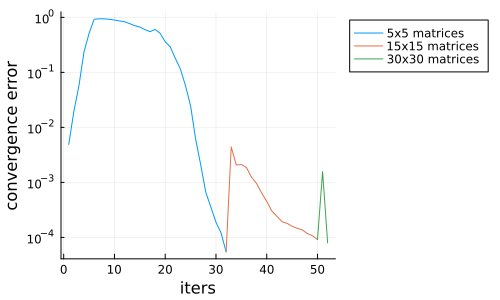

In [26]:
iters_cum = cumsum(iters)
inds = 1:iters_cum[1]
pl = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
for i in 2:length(iters)
    inds = iters_cum[i-1]:iters_cum[i]
   plot!(pl, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
end
plot(pl, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(500,300), legend=:outertopright)

In [27]:
spin(x, i) = 3-2x
m = only(means(spin, bp));

In [28]:
m_eq = equilibrium_magnetization(RandomRegular(k), J; β, h);

In [60]:
using Graphs, IndexedGraphs, Statistics

N = 10^3
g = random_regular_graph(N, k)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
bp_mc = mpbp(Glauber(ising, T); ϕ = fill(ϕᵢ, N))
sms = SoftMarginSampler(bp_mc);

In [61]:
sample!(sms, 50)
spin(x) = 3-2x
m_mc = [vec(spin.(mean(X, dims=1))) for X in sms.X];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:01


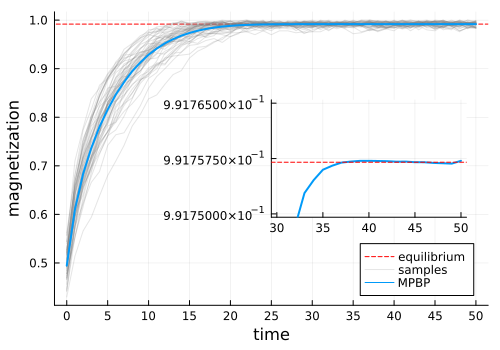

In [79]:
blue = theme_palette(:auto)[1]
pl = hline([m_eq], c=:red, ls=:dash, lw=1, label="equilibrium", legend=:bottomright)
plot!(pl, 0:T, m_mc, label=permutedims(["samples"; fill("", length(m_mc)-1)]), c=:gray, la=0.2)
plot!(pl, 0:T, m, lw=2, xlabel="time", ylabel="magnetization", msc=:auto, c=blue,
    size=(300,300), xticks=0:5:T, ms=2, label="MPBP")

yl = (0.99175,0.991765)
plot!(pl, xticks=30:5:T, ylims=yl, xlims=(30,T), yticks=(LinRange(yl...,3)),
    inset=(1, bbox(0.5, 0.3, 0.45, 0.4)), subplot=2)
plot!(pl[2], 0:T, m, lw=2, ylabel="", label="", ms=2, widen=true, msc=:auto, c=blue)
hline!(pl[2], [m_eq], c=:red, ls=:dash, lw=1, label="")
plot(pl, size=(500,350))

In [32]:
c = only(autocovariances(spin,bp));

In [33]:
using ColorSchemes
function plot_autocovs(c, T; skip_even=true, kw...)
    step = skip_even ? 2 : 1
    us = 8:4:28
    cg = cgrad(:matter, length(us), categorical=true)
    ylabel = "\$\\langle\\sigma_i^t\\sigma_i^{t+\\Delta t}\\rangle-" * 
        "\\langle\\sigma_i^t\\rangle\\langle\\sigma_i^{t+\\Delta t}\\rangle \$"
    xlabel = "\$\\Delta t \$"
    pl = plot(;xlabel, ylabel, legend=:outertopright, title="Glauber infinite $k-regular")
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-step:1, c[(0:step:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j]; kw...) 
    end
    pl
end  

plot_autocovs (generic function with 1 method)

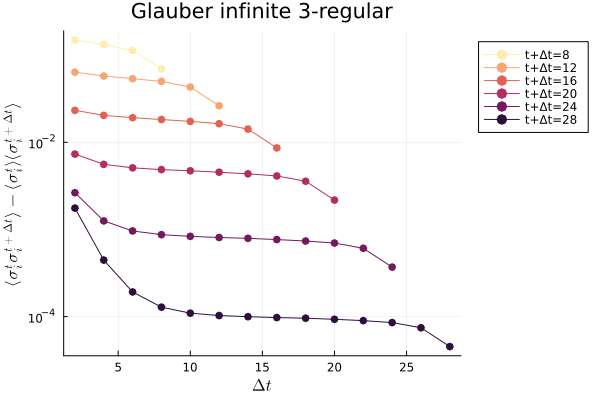

In [34]:
skip_even = true
pl_autocov = plot_autocovs(c, T; skip_even, yaxis=:log10)